In [1]:
%config Completer.use_jedi=False
import itertools as it
import wandb
import pandas as pd
import numpy as np
from typing import *
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sns.set_context("paper", font_scale=1)

In [2]:
def loss_to_bpc(loss: float) -> float:
    return float(loss) / np.log(2)

def load_runs(*experiments: str) -> wandb.apis.public.Runs:
    api = wandb.Api(dict(base_url="https://wandb.sourcevertex.net"))
    runs = api.runs(path="douglaso/scaled-matmuls", filters={
        "config.metadata.experiment": {"$in": experiments},
    })
    print(f"Loaded {len(runs)} runs", file=sys.stderr)
    return runs

runs = load_runs(
    "20220527_refresh_warmup",
    "20220527_refresh_warmup_fp16",
    "20220527_refresh_warmup_fp16_p2",
)
def run_stats(run):
    if run.state != "finished" or "broken" in run.tags:
        return

    model = run.config["model"]
    optimiser = run.config["training"]["optimiser"]
    return dict(
        id=run.id,
        # model
        variant="unit" if run.config["unit_scale"] else "regular",
        dtype=model["dtype"],
        depth=model["depth"],
        norm=model["residual"]["norm"] or "none",
        alpha=model["residual"]["alpha"] or "none",
        model=model["sequence"]["kind"],
        # optimiser
        optimiser=optimiser["kind"],
        lr=np.log(optimiser["learning_rate"])/np.log(2),
        loss_scale=run.config["training"]["loss_scale"],
        # stats
        weights=run.summary["n_weights_no_embedding"],
        valid_bpc=loss_to_bpc(run.summary["valid_loss"]),
        train_bpc=loss_to_bpc(run.summary["train_loss"]),
    )

df = pd.DataFrame.from_dict(filter(None, map(run_stats, runs)))

Loaded 2092 runs


In [3]:
dfm = (df.groupby(["variant", "loss_scale", "model", "depth", "norm", "alpha", "optimiser", "dtype"], dropna=False)
 .apply(lambda d: d.iloc[d.valid_bpc.argmin()])
 [["lr", "weights", "valid_bpc", "train_bpc"]]
 .reset_index()
 .sort_values("valid_bpc"))

In [4]:
print("Typical LR ranges:")
for (variant, optimiser), g in dfm.groupby(["variant", "optimiser"]):
    print(f"  {variant:<8} {optimiser:<6} {g.lr.quantile(0.1):<5} {g.lr.median():<5} {g.lr.quantile(0.9):<5}")

Typical LR ranges:
  regular  adamw  -12.0 -10.0 -8.0 
  regular  sgdm   -8.0  -4.0  -4.0 
  unit     adamw  -8.0  -6.0  -4.0 
  unit     sgdm   -14.0 -12.0 -10.0


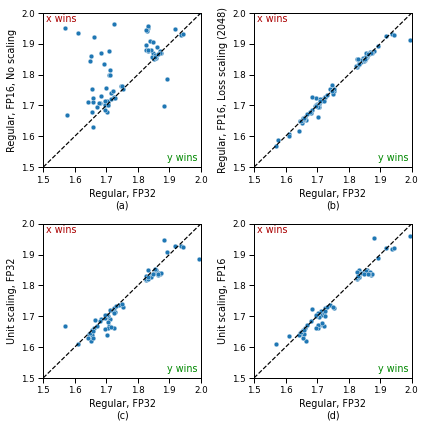

In [5]:
dfc = dfm.pivot(index=["model", "depth", "norm", "alpha", "optimiser"],
                columns=["variant", "dtype", "loss_scale"],
                values="valid_bpc").reset_index()

x = (("regular", "float32", 1), "Regular, FP32")
ys = {
    ("regular", "float16", 1): "Regular, FP16, No scaling",
    ("regular", "float16", 2048): "Regular, FP16, Loss scaling (2048)",
    ("unit", "float32", 1): "Unit scaling, FP32",
    ("unit", "float16", 1): "Unit scaling, FP16",
}
_, axs = plt.subplots(2, 2, figsize=(6, 6))
for label, ax, y in zip("abcd", axs.flatten(), ys):
    ax.plot([1.5, 2], [1.5, 2], "k--")
    sns.scatterplot(data=dfc, x=x[0], y=y, ax=ax)
    ax.set_xlim((1.5, 2))
    ax.set_ylim((1.5, 2))
    ax.set_xlabel(f"{x[1]}\n({label})")
    ax.set_ylabel(ys[y])
    ax.text(1.51, 1.97, "x wins", dict(color="#aa0000"))
    ax.text(1.99, 1.52, "y wins", dict(color="#008800"), ha="right")
plt.tight_layout()
plt.savefig("out/char_sweep.pdf");

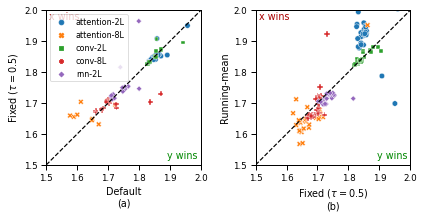

In [15]:
dfc = (dfm
    .pipe(lambda d: d.assign(depth=d.depth.map(str)))
    .pivot(index=["model", "depth", "norm", "optimiser", "variant", "dtype", "loss_scale"],
           columns=["alpha"],
           values="valid_bpc")
    .reset_index()
    .pipe(lambda d: d.assign(model_depth=dfc.apply(lambda s: f"{s.model}-{s.depth}L", axis=1)))
)

def scaling_label(s):
    if s == "none":
        return "Default"
    if s == "mean":
        return "Running-mean"
    return f"Fixed ($\\tau={s:.1f}$)"

xys = [
    ("none", 0.5),
    (0.5, "mean"),
]

_, axs = plt.subplots(1, 2, figsize=(6, 3))
for label, (x, y), ax in zip("ab", xys, axs.flatten()):
    sns.scatterplot(data=dfc, x=x, y=y, hue="model_depth", style="model_depth", ax=ax, s=30)
    ax.set_xlabel(f"{scaling_label(x)}\n({label})")
    ax.set_ylabel(f"{scaling_label(y)}")
    ax.set_xlim((1.5, 2))
    ax.set_ylim((1.5, 2))
    ax.plot([1.5, 2], [1.5, 2], "k--")
    ax.text(1.51, 1.97, "x wins", dict(color="#aa0000"))
    ax.text(1.99, 1.52, "y wins", dict(color="#008800"), ha="right")
    ax.set(adjustable="box", aspect="equal")
    ax.legend(fontsize=8)
    if label != "a":
        ax.legend_.remove()
plt.tight_layout()
plt.savefig("out/char_residual.pdf");